HAPI version: 1.2.2.2
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

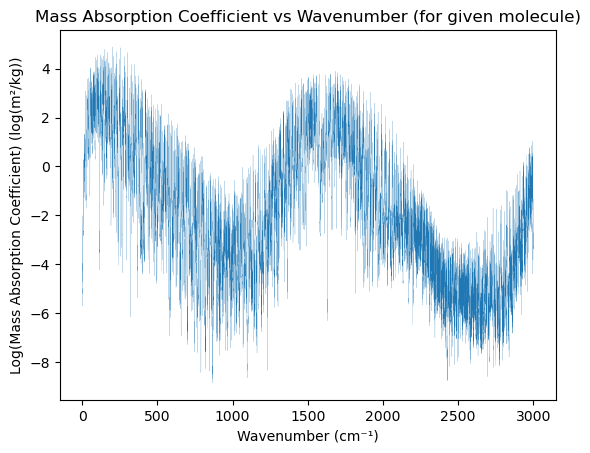

Using data

CO2
                     Lines parsed: 35010
H2O
                     Lines parsed: 23399

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CO2
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes writ

C:\Users\jacob\Research Winter Quarter 25'\research_functions.py:40: RuntimeWarning: divide by zero encountered in log10
  log_mass_absorption_coef= np.log10(mass_absorption_coef)  #OLD LOG MASS CALC


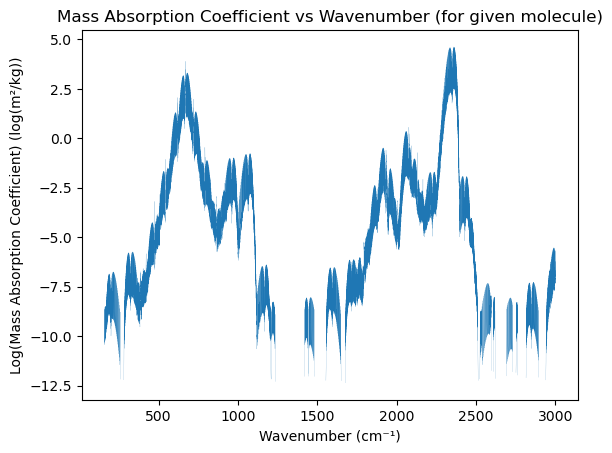

In [1]:
from research_functions import import_HAPI_data  
import numpy as np
from hapi import *
import matplotlib.pyplot as plt

molecular_weight_H2O = 0.018015
molecular_weight_CO2 = 0.04401

#test
wavenumber_H2O, H2O_log_coefs = import_HAPI_data("H2O",1,1, 0, 3000, .01805)
wavenumber_CO2, CO2__log_coefs = import_HAPI_data("CO2",2,1, 0, 3000, .04401)

In [2]:
!pip install torch torchvision torchaudio

In [3]:
!pip install --upgrade typing_extensions


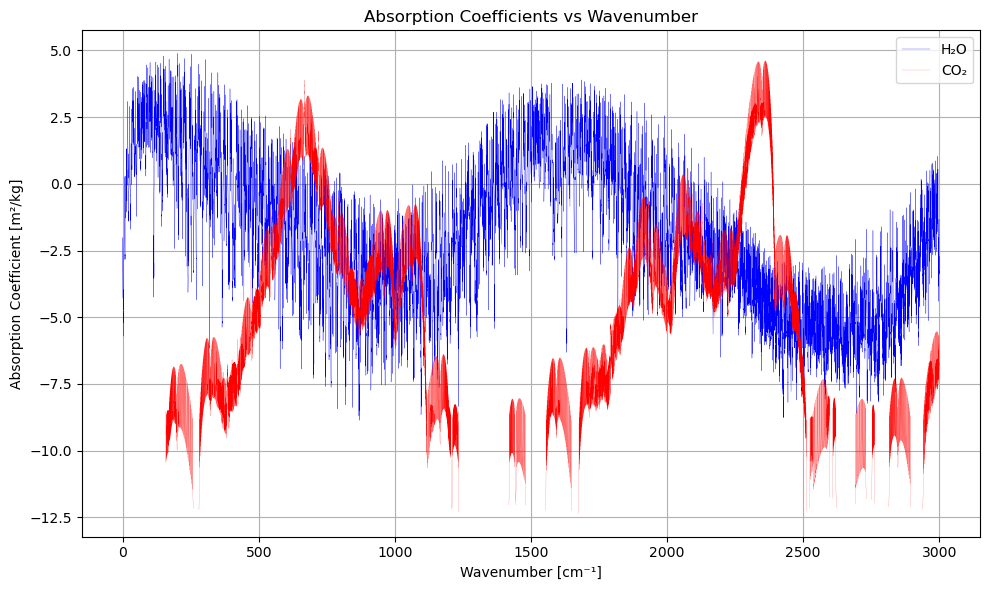

In [4]:
plt.figure(figsize=(10, 6))

# Plot H2O
plt.plot(wavenumber_H2O, H2O_log_coefs, label="H₂O", color='blue', lw=0.2)
plt.plot(wavenumber_CO2, CO2__log_coefs, label="CO₂", color='red', lw=0.1)

# Labels and legend
plt.xlabel("Wavenumber [cm⁻¹]")
plt.ylabel("Absorption Coefficient [m²/kg]")
plt.title("Absorption Coefficients vs Wavenumber")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [5]:
import torch 

x = torch.tensor(wavenumber_H2O).float().unsqueeze(1)
y = torch.tensor(H2O_log_coefs).float().unsqueeze(1)

x_mean, x_std = x.mean(), x.std()
x = (x - x_mean) / x_std

In [6]:
#model definition using pytorch
import torch.nn as nn

class SpectralNN(nn.Module):   #IF I WANT A DIFFERENT MODEL TYPE, I CAN SIMPLY JUST DEFINE A NEW CLASS LIKE THIS ONE
    def __init__(self):
        super(SpectralNN,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 64),  # Input layer: 1 feature → 64 neurons
            nn.LeakyReLU(0.01),         # Activation function
            nn.Linear(64, 64), # Hidden layer: 64 → 64 neurons
            nn.LeakyReLU(0.01),         # Activation function
            nn.Linear(64, 1)   # Output layer: 64 → 1 output
        )

    def forward(self, x):
        return self.model(x)
            

In [7]:
#model training
H2O_model1 = SpectralNN() #instance of the neural network class we created above
H2O_loss_function = nn.MSELoss()  #a loss function object using mean square error 
H2O_optimizer = torch.optim.Adam(H2O_model1.parameters(), lr=1e-3)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

for epoch in range(1000):
    H2O_model1.train()  #sets model to training mode, not neccesary for this basic model

    y_pred = H2O_model1(x) #computes predicted values ie forward pass
    H2O_loss = H2O_loss_function(y_pred, y) #computes loss using MSE

    H2O_optimizer.zero_grad() #clears out old gradients from last step
    H2O_loss.backward() #computes loss gradients for backward pass
    H2O_optimizer.step()  #uses backward pass to update model weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {H2O_loss.item():.4f}") #prints loss at every 100th epoch

Epoch 0: Loss = 12.4751
Epoch 100: Loss = 4.2241
Epoch 200: Loss = 3.0373
Epoch 300: Loss = 2.5212
Epoch 400: Loss = 2.1954
Epoch 500: Loss = 2.0332
Epoch 600: Loss = 1.9574
Epoch 700: Loss = 1.9151
Epoch 800: Loss = 1.8887
Epoch 900: Loss = 1.8711



Final Loss after training: 1.8570


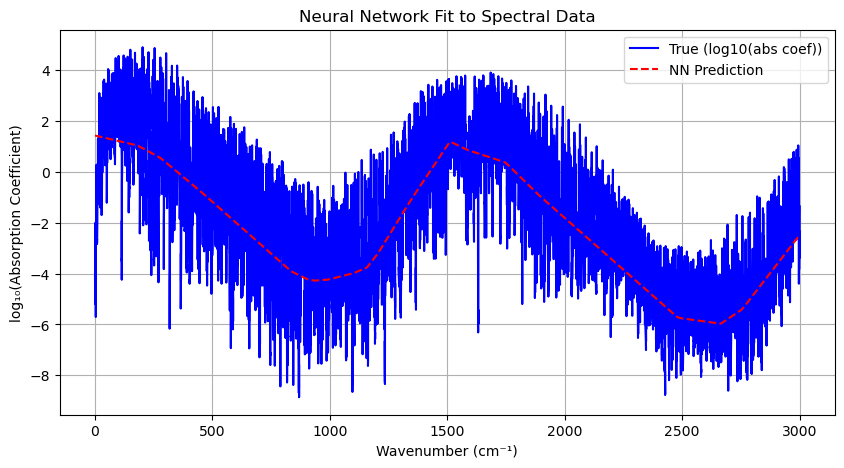

In [16]:
#evaluation/plotting fit

H2O_model1.eval()
#final loss numbers
H2O_final_pred = H2O_model1(x)
H2O_final_loss = H2O_loss_function(H2O_final_pred, y)
print(f"\nFinal Loss after training: {H2O_final_loss.item():.4f}")

with torch.no_grad(): #uses torch without gradient since evaluation doesn't need gradients
    y_pred = H2O_model1(x)  #gets y_pred for comparision

# Convert tensors to NumPy arrays for plotting
x_vals = (x * x_std + x_mean).squeeze().numpy() #converts back to original units
y_true = y.squeeze().numpy()
y_pred_vals = y_pred.squeeze().numpy()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_true, label='True (log10(abs coef))', color='blue')
plt.plot(x_vals, y_pred_vals, label='NN Prediction', color='red', linestyle='--')
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("log₁₀(Absorption Coefficient)")
plt.title("Neural Network Fit to Spectral Data")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
#here's an example of how to input any wavenumber and then retrieve the neural networks prediction
test_wavenumber = 550.0

# Step 1: Convert to tensor and reshape
x_test = torch.tensor([[(test_wavenumber - x_mean) / x_std]], dtype=torch.float32).unsqueeze(0)

# Step 2: Use the model to predict
H2O_model1.eval()  # set model to evaluation mode (no dropout, no gradient tracking)
with torch.no_grad():  # don't compute gradients for inference
    y_pred = H2O_model1(x_test).item()  # NN predicts log10(absorption coefficient)
# Step 4: Print results
print(f"\nPrediction for wavenumber {test_wavenumber} cm⁻¹:")
print(f"  Absorption Coefficient (m²/kg) = {y_pred:.4e}")


Prediction for wavenumber 550.0 cm⁻¹:
  Absorption Coefficient (m²/kg) = -1.5889e+00


Using data

CO2
                     Lines parsed: 68577
H2O
                     Lines parsed: 23399

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CO2
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes writ

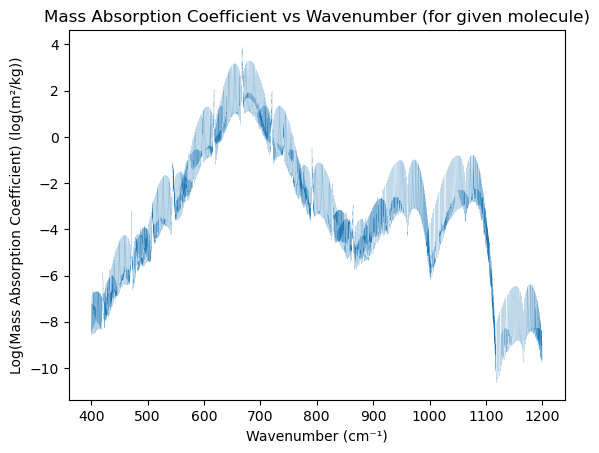

In [20]:
wavenumber_CO2_1, CO2_log_coefs_1 = import_HAPI_data("CO2",2,1, 400, 1200, .04401)

In [22]:
a = torch.tensor(wavenumber_CO2_1).float().unsqueeze(1)
b = torch.tensor(CO2_log_coefs_1).float().unsqueeze(1)

a_mean, a_std = a.mean(), a.std()
a = (a - a_mean) / a_std

In [24]:
# CO2 model training
CO2_model1 = SpectralNN() #instance of the neural network class we created above
CO2_loss_function1 = nn.MSELoss()  #a loss function object using mean square error 
CO2_optimizer1 = torch.optim.Adam(CO2_model1.parameters(), lr=1e-3)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

for epoch in range(1000):
    CO2_model1.train()  #sets model to training mode, not neccesary for this basic model

    b_pred1 = CO2_model1(a) #computes predicted values ie forward pass
    CO2_loss1 = CO2_loss_function1(b_pred1, b) #computes loss using MSE

    CO2_optimizer1.zero_grad() #clears out old gradients from last step
    CO2_loss1.backward() #computes loss gradients for backward pass
    CO2_optimizer1.step()  #uses backward pass to update model weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {CO2_loss1.item():.4f}") #prints loss at every 100th epoch

Epoch 0: Loss = 19.2707
Epoch 100: Loss = 3.7023
Epoch 200: Loss = 2.3203
Epoch 300: Loss = 1.6468
Epoch 400: Loss = 1.2782
Epoch 500: Loss = 1.0573
Epoch 600: Loss = 0.9783
Epoch 700: Loss = 0.9575
Epoch 800: Loss = 0.9511
Epoch 900: Loss = 0.9474



Final Loss after training: 0.9439


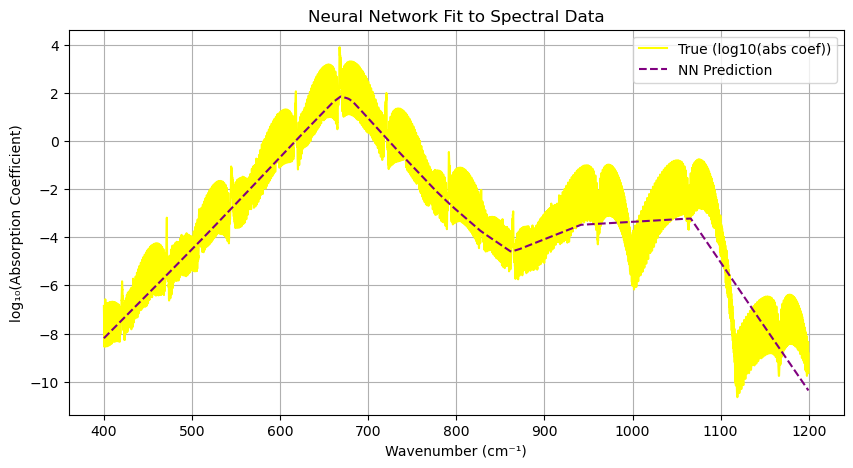

In [26]:
CO2_model1.eval()
#final loss numbers
final_pred_CO2_1 = CO2_model1(a)
final_loss_CO2_1 = CO2_loss_function1(final_pred_CO2_1, b)
print(f"\nFinal Loss after training: {final_loss_CO2_1.item():.4f}")

with torch.no_grad(): #uses torch without gradient since evaluation doesn't need gradients
    b_pred1 = CO2_model1(a)  #gets y_pred for comparision

# Convert tensors to NumPy arrays for plotting
a_vals1 = (a * a_std + a_mean).squeeze().numpy() #converts back to original units
b_true1 = b.squeeze().numpy()
b_pred_vals1 = b_pred1.squeeze().numpy()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(a_vals1, b_true1, label='True (log10(abs coef))', color='yellow')
plt.plot(a_vals1, b_pred_vals1, label='NN Prediction', color='purple', linestyle='--')
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("log₁₀(Absorption Coefficient)")
plt.title("Neural Network Fit to Spectral Data")
plt.legend()
plt.grid(True)
plt.show()

Using data

CO2
                     Lines parsed: 35010
H2O
                     Lines parsed: 23399

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CO2
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes written to data/CO2.data
  65536 bytes writ

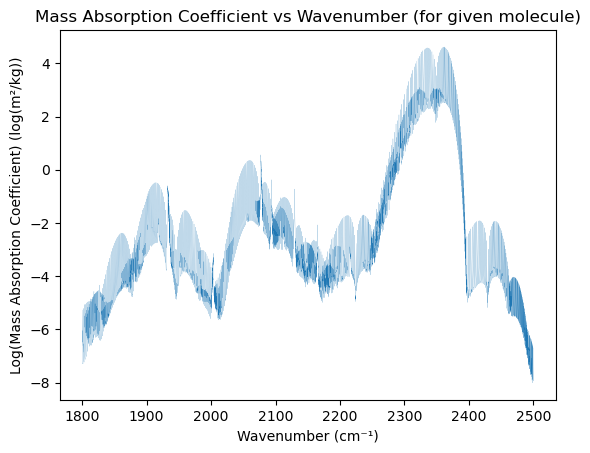

In [28]:
wavenumber_CO2_2, CO2_log_coefs_2 = import_HAPI_data("CO2",2,1, 1800, 2500, .04401)

In [35]:
a1 = torch.tensor(wavenumber_CO2_2).float().unsqueeze(1)
b1 = torch.tensor(CO2_log_coefs_2).float().unsqueeze(1)

a1_mean, a1_std = a1.mean(), a1.std()
a1 = (a1 - a1_mean) / a1_std

In [37]:
# CO2 model training
CO2_model2 = SpectralNN() #instance of the neural network class we created above
CO2_loss_function2 = nn.MSELoss()  #a loss function object using mean square error 
CO2_optimizer2 = torch.optim.Adam(CO2_model2.parameters(), lr=1e-3)   #adam optimizer, combines momentum and RMSProp along with what we assume is gradient descent 

for epoch in range(1000):
    CO2_model2.train()  #sets model to training mode, not neccesary for this basic model

    b1_pred2 = CO2_model2(a1) #computes predicted values ie forward pass
    CO2_loss2 = CO2_loss_function2(b1_pred2, b1) #computes loss using MSE

    CO2_optimizer2.zero_grad() #clears out old gradients from last step
    CO2_loss2.backward() #computes loss gradients for backward pass
    CO2_optimizer2.step()  #uses backward pass to update model weights

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {CO2_loss2.item():.4f}") #prints loss at every 100th epoch

Epoch 0: Loss = 12.7548
Epoch 100: Loss = 4.3644
Epoch 200: Loss = 3.2092
Epoch 300: Loss = 1.5827
Epoch 400: Loss = 1.1959
Epoch 500: Loss = 1.1294
Epoch 600: Loss = 1.1057
Epoch 700: Loss = 1.0886
Epoch 800: Loss = 1.0710
Epoch 900: Loss = 1.0483



Final Loss after training: 1.0185


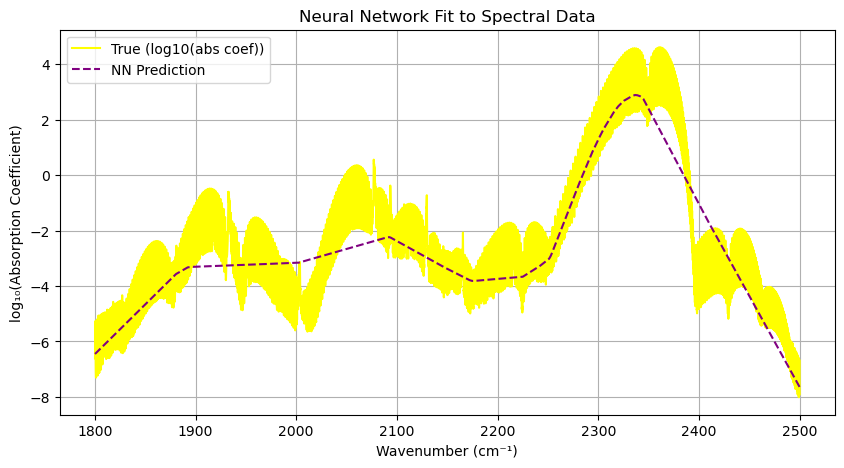

In [41]:
CO2_model2.eval()
#final loss numbers
final_pred_CO2_2 = CO2_model2(a1)
final_loss_CO2_2 = CO2_loss_function2(final_pred_CO2_2, b1)
print(f"\nFinal Loss after training: {final_loss_CO2_2.item():.4f}")

with torch.no_grad(): #uses torch without gradient since evaluation doesn't need gradients
    b1_pred2 = CO2_model2(a1)  #gets y_pred for comparision

# Convert tensors to NumPy arrays for plotting
a_vals2 = (a1 * a1_std + a1_mean).squeeze().numpy() #converts back to original units
b_true2 = b1.squeeze().numpy()
b_pred_vals2 = b1_pred2.squeeze().numpy()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(a_vals2, b_true2, label='True (log10(abs coef))', color='yellow')
plt.plot(a_vals2, b_pred_vals2, label='NN Prediction', color='purple', linestyle='--')
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("log₁₀(Absorption Coefficient)")
plt.title("Neural Network Fit to Spectral Data")
plt.legend()
plt.grid(True)
plt.show()

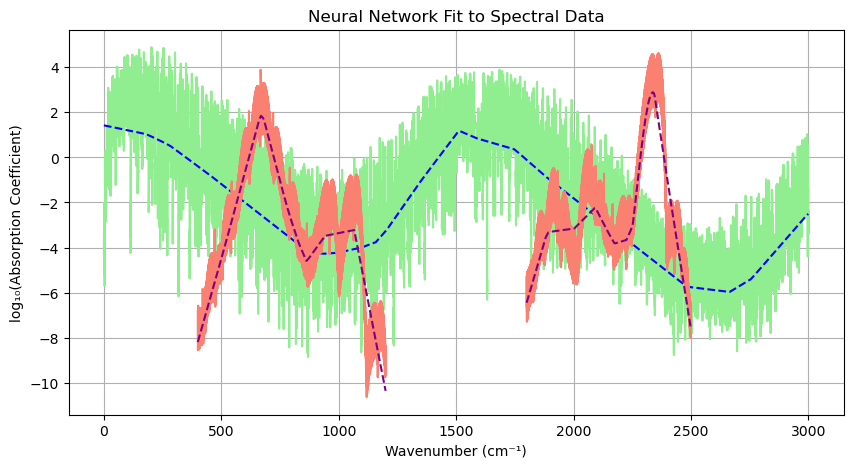

In [49]:
#overlaying all plots
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_true, label='True (log10(abs coef))', color='lightgreen')
plt.plot(x_vals, y_pred_vals, label='NN Prediction', color='blue', linestyle='--')

plt.plot(a_vals1, b_true1, label='True (log10(abs coef))', color='salmon')
plt.plot(a_vals1, b_pred_vals1, label='NN Prediction', color='purple', linestyle='--')

plt.plot(a_vals2, b_true2, label='True (log10(abs coef))', color='salmon')
plt.plot(a_vals2, b_pred_vals2, label='NN Prediction', color='purple', linestyle='--')
plt.xlabel("Wavenumber (cm⁻¹)")
plt.ylabel("log₁₀(Absorption Coefficient)")
plt.title("Neural Network Fit to Spectral Data")
plt.grid(True)
plt.show()

In [83]:
#here's an example of how to input any wavenumber and then retrieve the neural networks prediction
#here we will write the code to achieve the greatest absoprtion coeffcient at a specific wavenumber
input_wn = 800

# Step 1: Convert to tensor and reshape
x_test = torch.tensor([[(input_wn - x_mean) / x_std]], dtype=torch.float32).unsqueeze(0)

a1_test = torch.tensor([[(input_wn - a_mean) / a_std]], dtype=torch.float32).unsqueeze(0)
a2_test = torch.tensor([[(input_wn - a1_mean) / a1_std]], dtype=torch.float32).unsqueeze(0)

# Step 2: Use the model to predict
H2O_model1.eval()  # set model to evaluation mode (no dropout, no gradient tracking)
CO2_model1.eval()
CO2_model2.eval()

with torch.no_grad():  # don't compute gradients for inference
    y_pred = H2O_model1(x_test).item()  # NN predicts log10(absorption coefficient)
result = y_pred

if input_wn > 400 and input_wn < 1200:
    with torch.no_grad():  # don't compute gradients for inference
        b1_pred = CO2_model1(a1_test).item()  # NN predicts log10(absorption coefficient)
    if y_pred <= b1_pred:
        result = b1_pred

if input_wn > 1800 and input_wn < 2500:
    with torch.no_grad():  # don't compute gradients for inference
        b2_pred = CO2_model2(a2_test).item()  # NN predicts log10(absorption coefficient)
        if y_pred <= b2_pred:
            result = b2_pred

# Step 4: Print results
print(f"\nPrediction for wavenumber {input_wn} cm⁻¹:")
print(f"  Absorption Coefficient (log10 form) (m²/kg) = {result}")
real_result = 10**result
print(f"  Absorption Coefficient (original form) (m²/kg) = {real_result}")


Prediction for wavenumber 800 cm⁻¹:
  Absorption Coefficient (log10 form) (m²/kg) = -2.8665409088134766
  Absorption Coefficient (original form) (m²/kg) = 0.0013597500742011364


In [71]:
#ok so we have established the framework for our neural networks and code to output greatest absoprtion coefficient corresponding to wavenumber. \
#next we make this project visible, meaning upload to github, make readme/abstract and possible even an interface that gives both the visual and the input/output of the final function

In [85]:
#creating data files
import pandas as pd

h2o_df = pd.DataFrame({'wavenumber_cm^-1': wavenumber_H2O, 'absorption_coef': H2O_log_coefs})
h2o_df.to_csv('h2o_absorption_wn0-3000_260K_500hPa.csv', index=False)

co2_df1 = pd.DataFrame({'wavenumber_cm^-1': wavenumber_CO2_1, 'absorption_coef': CO2_log_coefs_1})
co2_df1.to_csv('co2_absorption_wn400-1200_260K_500hPa.csv', index=False)

co2_df2 = pd.DataFrame({'wavenumber_cm^-1': wavenumber_CO2_2, 'absorption_coef': CO2_log_coefs_2})
co2_df2.to_csv('h2o_absorption_wn1800-2500_260K_500hPa.csv', index=False)